<h1><center> Quantitative Finance Bootcamp Erdos Institute <center></h1>
<h1><center> Mini project 4: Impact of a non-constant $\sigma$ on the distribution of profits of hedging </center></h1>


Aim: For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. We model the stock paths and the volatility using the Heston model.

In [1]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Setting global matplotlib parameters
import matplotlib as mpl
import matplotlib.dates as mdates 
mpl.rcParams["xtick.labelsize"] = 22
mpl.rcParams["ytick.labelsize"] = 22
mpl.rcParams['axes.titlesize'] = 22 
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams["mathtext.fontset"] = 'cm'

%run functions.py

## Simulating stock paths using the Heston model

In [2]:
def heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims=1, mu=0, return_vol=False):
    """
    Simulation of stock path movements under the Heston stochastic volatility model.
    
    Parameters:
    - S0 (float): Initial stock price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Total time horizon (in years)
    - n_steps (int): Number of time steps
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions
    - n_sims (int): Number of simulated paths
    - mu (float): Excess drift of log-returns
    - return_vol (bool): Whether to return the simulated variance paths

    Returns:
    - paths (ndarray): Simulated stock price paths of shape (n_sims, n_steps + 1)
    - vols (ndarray, optional): Simulated variance paths if return_vol is True
    """
    dt = t / n_steps
    N1 = np.random.normal(0, 1, size=(n_sims, n_steps))
    N2 = np.random.normal(0, 1, size=(n_sims, n_steps))
    Y = rho * N1 + np.sqrt(1 - rho**2) * N2

    paths = np.zeros((n_sims, n_steps + 1))
    vols = np.zeros((n_sims, n_steps + 1))
    paths[:, 0] = S0
    vols[:, 0] = v0

    for i in range(n_steps):
        vols[:, i + 1] = np.abs(vols[:, i] + kappa * (theta - vols[:, i]) * dt +
                                xi * np.sqrt(np.maximum(vols[:, i], 0) * dt) * N1[:, i])
        paths[:, i + 1] = paths[:, i] * np.exp((mu + r - 0.5 * vols[:, i]) * dt +
                                               np.sqrt(np.maximum(vols[:, i], 0) * dt) * Y[:, i])
    
    return (paths, vols) if return_vol else paths

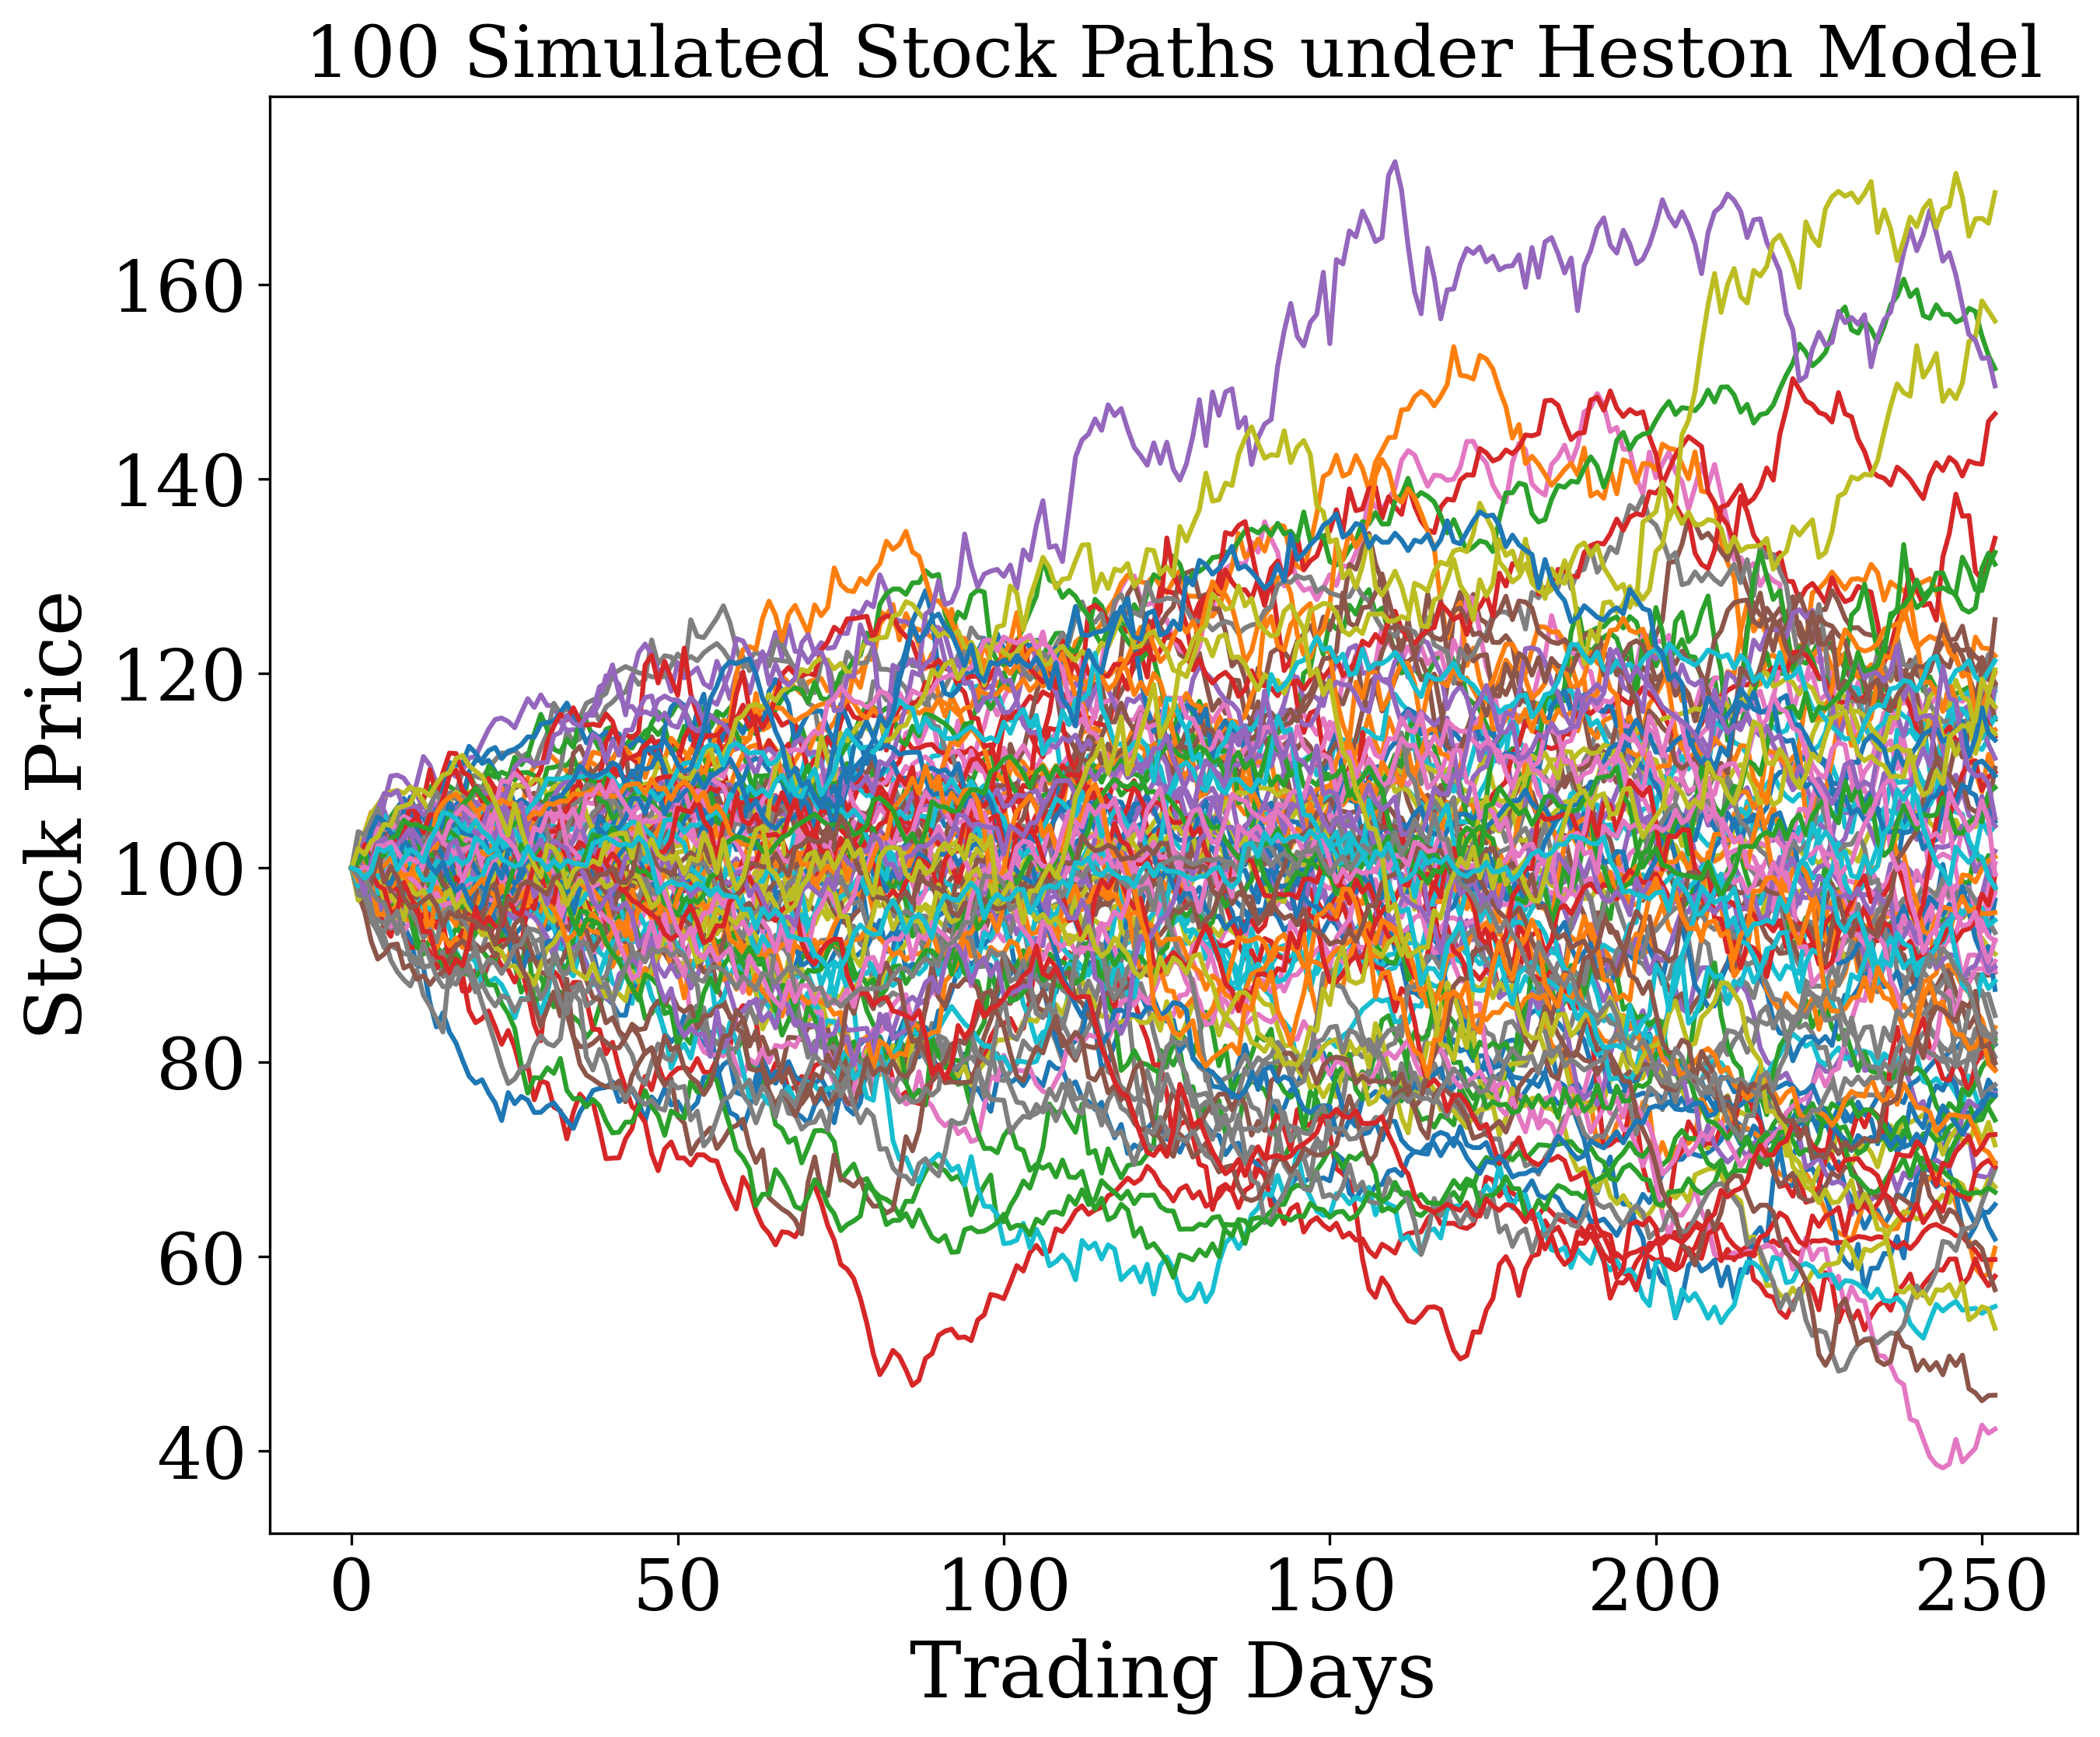

In [3]:
kappa = 2.4 #Mean reversion rate of variance of log-returns (Typical range 1 to 5)
theta = .3**2 #Long run variance of log-returns
xi = .43 # Volatility of Volatility (Typical range .2 to 1)
v0 = .22**2 #Initial variance of log-returns
rho = -.6 #Correlation of random noise of variance and log-returns (Typical range -.9 to -.4)
S0 = 100 #Initial Stock Value
t = 1 #Time horizon
n_steps = 252 #Number of steps in each simulation
r = .039 #Risk-free interest rate
n_sims = 100 #Number of simulations
mu = 0 #Excess drift of log returns


heston_paths = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims, mu)


plt.figure(figsize = (10,8))

for path in heston_paths:
    plt.plot(path)
    
plt.title(f'{n_sims} Simulated Stock Paths under Heston Model')
plt.xlabel('Trading Days')
plt.ylabel('Stock Price')

plt.show()

## Delta Hedging

Delta-hedging is the foundational risk-management technique that removes an option portfolio’s sensitivity to **spot-price moves only**.  Let $V(S,t)$ be the option price, where $S$ is the underlying price and time-to-maturity is $t$.  Its **delta** is

$$
\Delta \;=\; \frac{\partial V}{\partial S},
$$

which measures the dollar change in option value for a \$1 change in the underlying.  Suppose we are *short* one call with delta $\Delta_1<0$.  To neutralise this exposure we trade the underlying stock itself, whose delta is exactly +1 per share.  Holding

$$
\Phi \;=\; \Delta_1,
$$

shares **long** (if $\Delta_1<0$) or **short** (if $\Delta_1>0$) causes the combined position—short the call and long $\Phi$ shares—to have net delta

$$
\Delta_{\text{net}} \;=\; -\Delta_1 + \Phi \;=\; 0,
$$

making it locally insensitive to infinitesimal moves in $S$.  Because an option’s delta drifts with both time decay and realised price changes, this hedge must be refreshed at discrete intervals—daily, hourly, or whenever risk limits dictate.  In the ideal mathematical limit of continuous re-hedging the replication error vanishes; in practice, discrete updates leave residual **gamma risk** (sensitivity to the *second* derivative), so small but manageable profit-and-loss fluctuations persist.

Now we shall investigate the profit and loss distribution of Heston model with daily delta hedging and no drift. 

## P&L distribution of Heston model with 252 Delta Hedges with no drift

In [ ]:
def bs_call_delta(S0, K, sigma, t, r):
    """
    Returns the Delta (sensitivity to spot price) of a European call option
    under Black-Scholes assumptions.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to maturity (in years)
        r (float): Risk-free interest rate

    Returns:
        float: Delta of Call Option
    """
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    return norm.cdf(d1)

def heston_call_MC(S0, K, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims=2500, mu=0):
    """
    Monte-Carlo Simulation of Call Option under Heston model with Black-Scholes Delta control variates
    
    Parameters:
    - S0 (float): Initial stock price
    - K (float): Strike Price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Total time horizon (in years)
    - n_steps (int): Number of time steps
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions
    - n_sims (int): Number of simulated paths
    - mu (float): Excess drift of log-returns
    - return_vol (bool): Whether to return the simulated variance paths

    Returns:
    - call_payouts_hedged (ndarray): Simulated payouts of a call-option with hedging
    - call_payout (ndarray): Simulated payouts of a call-option without hedging
    """
    
    
    paths, vols = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims, mu, return_vol=True)
    
    dt = t / n_steps
    
    # Compute BS deltas from previous steps volatility across all steps (n_steps, n_sims)
    # This is only an approximation of Delta of call option under Heston model.
    # The black-scholes deltas and Heston deltas are correlated enough so that black-scholes deltas
    # still work as a control variate in Monte-Carlo Simulation of Heston model option pricing
    
    deltas = np.array([bs_call_delta(paths[:, i], K, np.sqrt(vols[:,i]), t - i * dt, r) for i in range(n_steps)]).T  
    
    # Stock P&L from delta hedge
    stock_profits_steps = (paths[:, 1:] - np.exp(r*dt)*paths[:, :-1]) * deltas * np.exp(-r * np.arange(1, n_steps + 1) * dt)
    stock_profits = np.sum(stock_profits_steps, axis=1)

    # Call payouts
    call_payouts = np.maximum(paths[:, -1] - K, 0) * np.exp(-r * t)

    # Adjusted estimator
    call_payouts_hedged = call_payouts - stock_profits

    return call_payouts_hedged, call_payouts

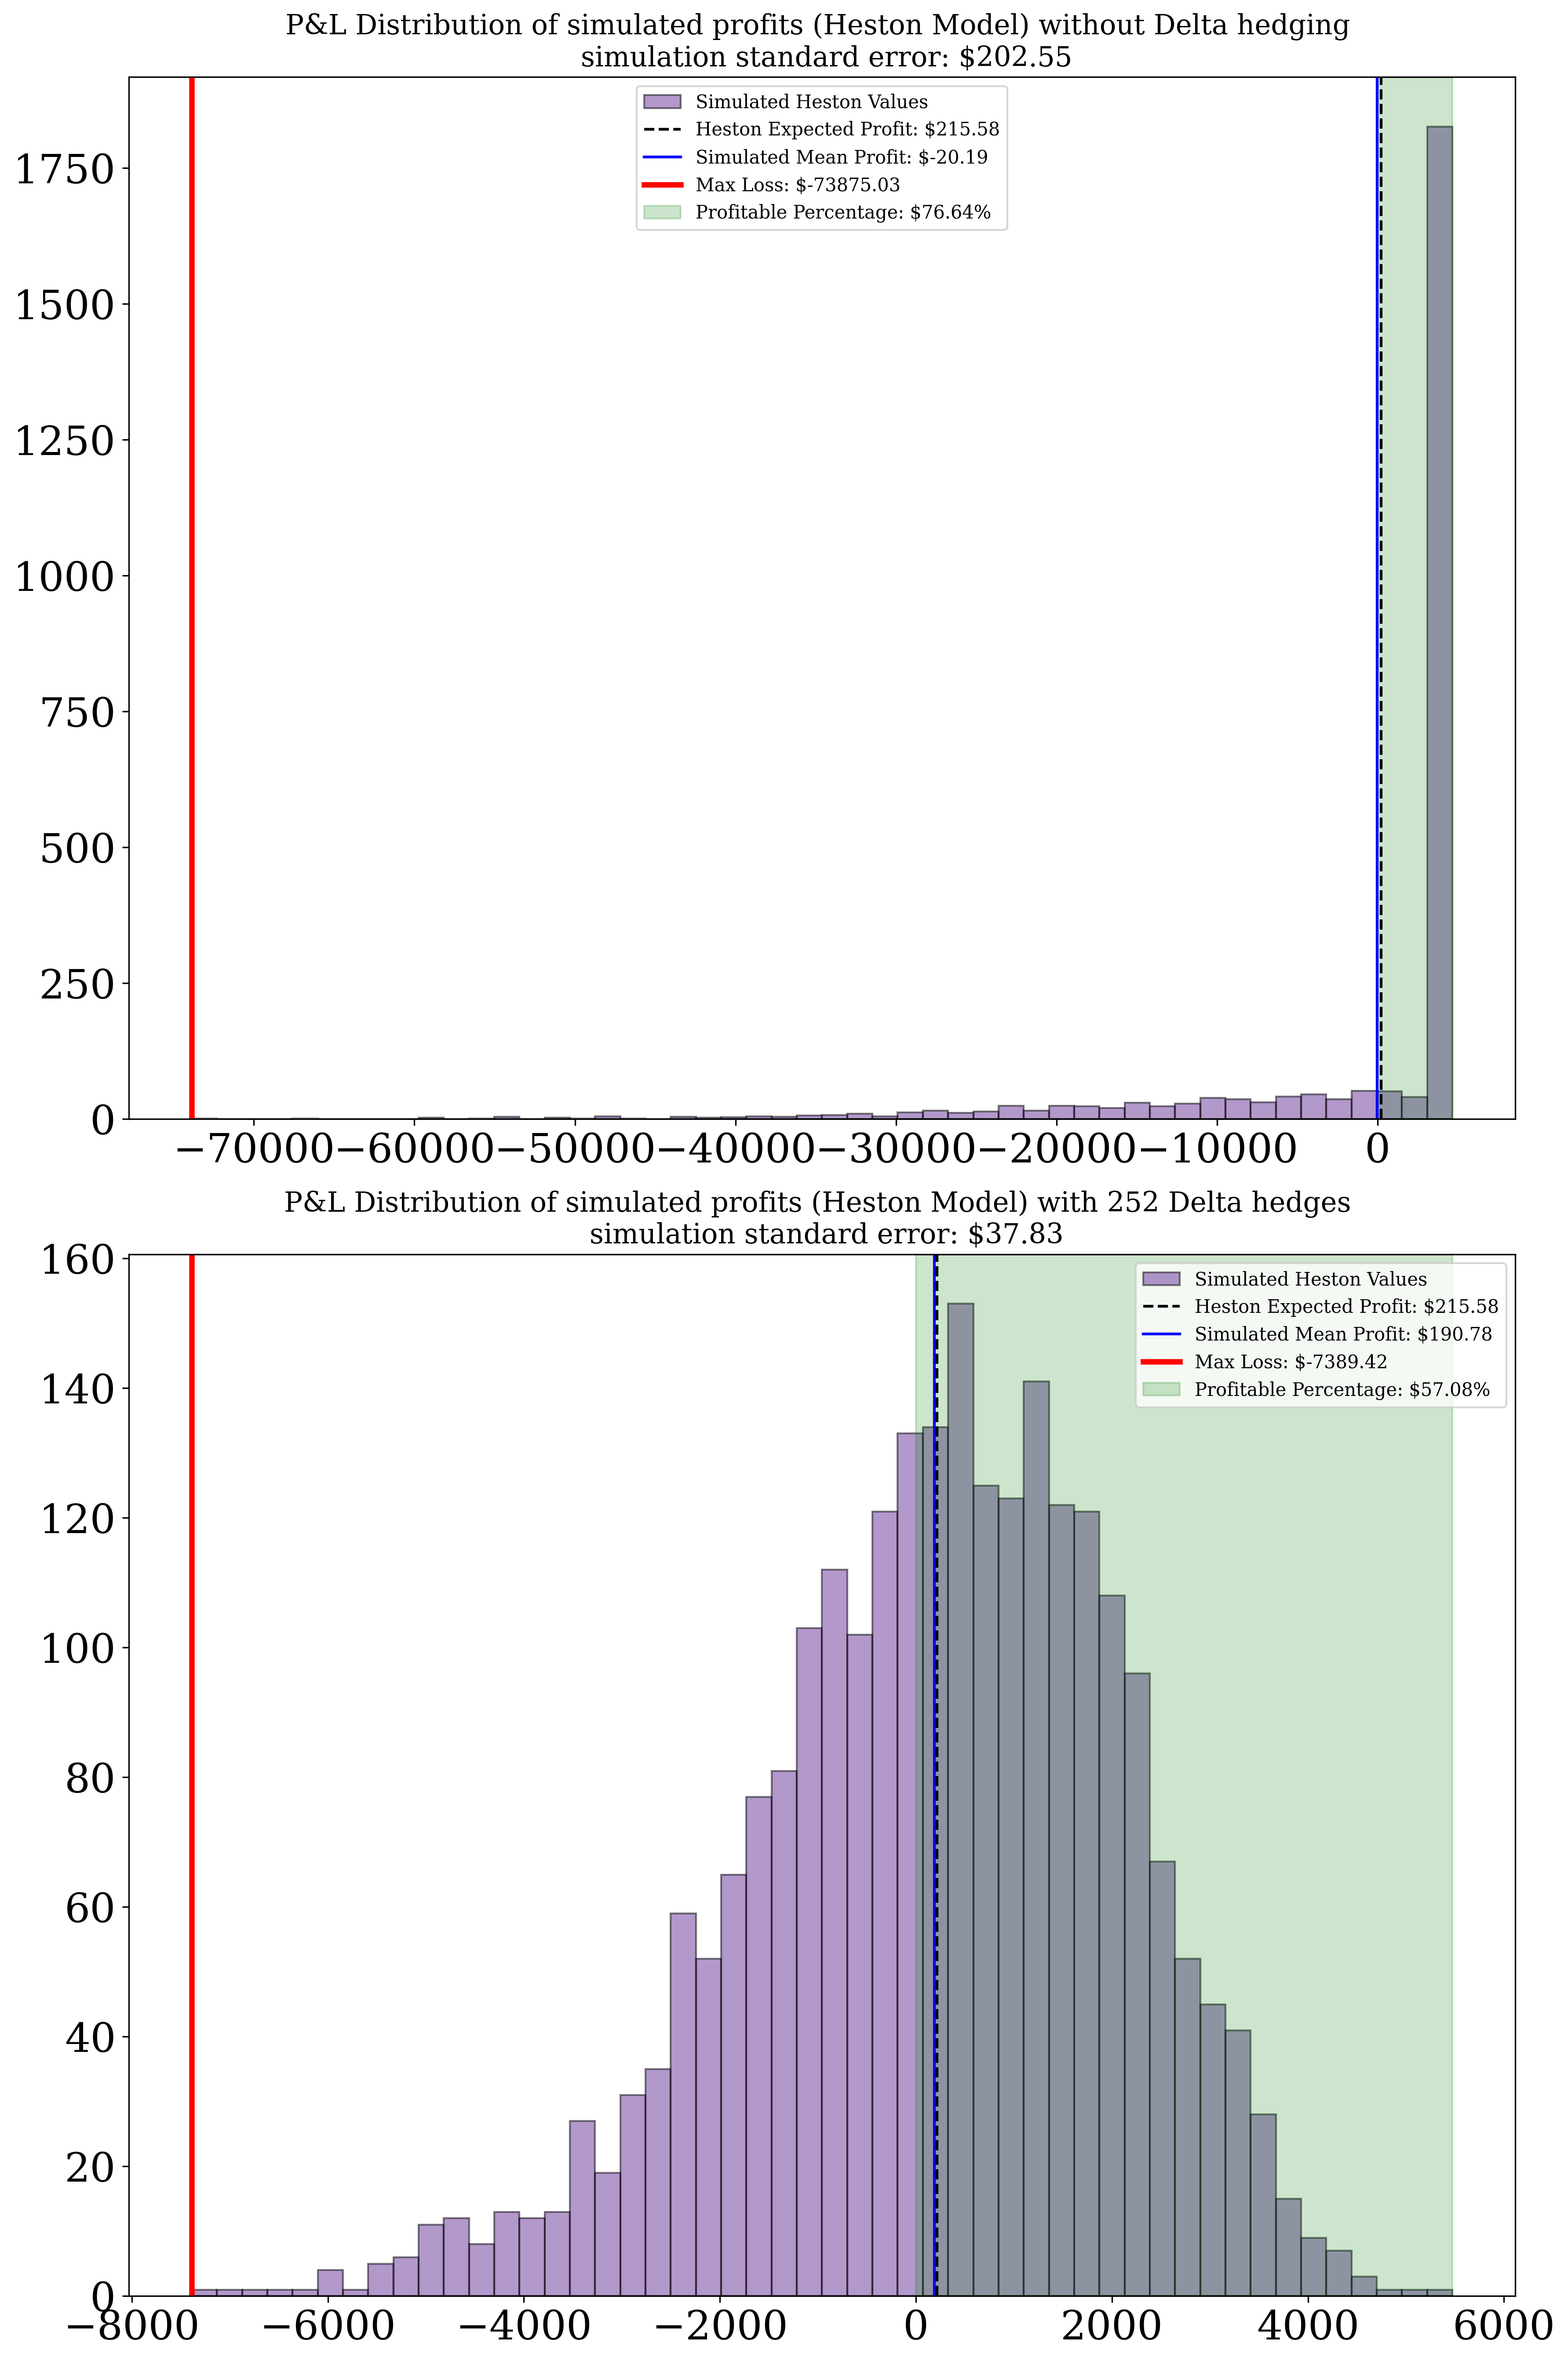

In [9]:
S0 = 85 #Initial Stock Value
K = 100
t = 1 #Time horizon
kappa = 2.4 #Mean reversion rate of variance of log-returns (Typical range 1 to 5)
theta = .3**2 #Long run variance of log-returns
xi = .43 # Volatility of Volatility (Typical range .2 to 1)
v0 = .22**2 #Initial variance of log-returns
rho = -.6 #Correlation of random noise of variance and log-returns (Typical range -.9 to -.4)
r = .039 #Risk-free interest rate
mu = 0 #Excess drift of log returns

n_sims = 2500  #Number of simulations
n_hedges = 252  # number of hedges
num_options = 1000

heston_premium= heston_call(S0, K, v0+0.01, r, t, kappa, theta, xi, rho)

heston_call_price = heston_call(S0, K, v0, r, t, kappa, theta, xi, rho)
sold_calls_hedged,sold_call_nohedge = heston_call_MC(S0, K, v0, r, t, n_hedges, kappa, theta, xi, rho, n_sims, mu)
profits_hedged = num_options*(heston_premium - sold_calls_hedged)
profits_nohedge = num_options*(heston_premium - sold_call_nohedge)
profit_percent_hedged = np.mean(profits_hedged>=0)*100
profit_percent_nohedge = np.mean(profits_nohedge>=0)*100

fig,axes = plt.subplots(2,1, figsize = (12,18))

axes[0].hist(profits_nohedge, bins = 50, alpha = .5, color = 'rebeccapurple', edgecolor='black', label = 'Simulated Heston Values')
axes[1].hist(profits_hedged, bins = 50, alpha = .5, color = 'rebeccapurple', edgecolor='black', label = 'Simulated Heston Values')

axes[0].axvline(num_options*(heston_premium-heston_call_price), label = f'Heston Expected Profit: ${num_options*(heston_premium-heston_call_price):.2f}', color = 'black',linestyle="--")
axes[1].axvline(num_options*(heston_premium-heston_call_price), label = f'Heston Expected Profit: ${num_options*(heston_premium-heston_call_price):.2f}', color = 'black',linestyle="--")

axes[0].axvline(np.mean(profits_nohedge), label = f'Simulated Mean Profit: ${np.mean(profits_nohedge):.2f}', color = 'blue',linestyle="-")
axes[1].axvline(np.mean(profits_hedged), label = f'Simulated Mean Profit: ${np.mean(profits_hedged):.2f}', color = 'blue',linestyle="-")

axes[0].axvline(np.min(profits_nohedge), label = f'Max Loss: ${np.min(profits_nohedge):.2f}', color = 'red',linewidth=3)
axes[1].axvline(np.min(profits_hedged), label = f'Max Loss: ${np.min(profits_hedged):.2f}', color = 'red',linewidth=3)

axes[0].axvspan(0,np.max(profits_nohedge), color='green', alpha=0.2, label = f'Profitable Percentage: ${profit_percent_nohedge:.2f}%')
axes[1].axvspan(0,np.max(profits_hedged), color='green', alpha=0.2, label = f'Profitable Percentage: ${profit_percent_hedged:.2f}%')

axes[0].legend()
axes[1].legend()
axes[0].set_title(f'P&L Distribution of simulated profits (Heston Model) without Delta hedging \n simulation standard error: ${np.std(profits_nohedge)/np.sqrt(n_sims):.2f}',size = 15)
axes[1].set_title(f'P&L Distribution of simulated profits (Heston Model) with {n_hedges} Delta hedges \n simulation standard error: ${np.std(profits_hedged)/np.sqrt(n_sims):.2f}',size = 15)
plt.tight_layout()
plt.savefig("PLHeston_noHedgevsDeltaHedge.png")
plt.show()

## Observation

The two histograms compare simulated profit-and-loss (P&L) outcomes for a selling 1000 call option without any hedge (top panel) and with a daily delta hedge (bottom panel) under Heston model. The top distribution is extremely left-skewed.  While most simulations cluster near zero, occasional volatility spikes produce catastrophic losses. The lower histogram is noticeably tighter and almost symmetric around a small positive mean.  The worst loss is now roughly reduced by about one-tenth of the unhedged tail. The Monte-Carlo standard error also changes by a factor of nearly six, confirming quantitatively that delta hedging slashes path-to-path variability. The simulated mean P&L shifts to the right after hedging.  This maybe due to our approximation that we price and hedge with Black–Scholes greeks but simulate Heston paths, so the discrete hedge does not fully capture stochastic-volatility risk. Thus, Delta hedging dramatically reduces extreme downside risk—almost an order-of-magnitude improvement—at the cost of more frequent trading.  Although the mean profit rises modestly, the real benefit is the compression of the loss tail and the drop in P&L variance.



## Delta-Vega Hedging

Delta–vega hedging extends the basic delta-hedging idea by also cancelling an option portfolio’s sensitivity to changes in implied volatility.  In mathematical terms, let $V(S,\sigma,t)$ be the option price, where $S$ is the spot price and $\sigma$ the implied volatility.  Its **delta** is $\Delta=\partial V/\partial S$ and its **vega** is $\nu=\partial V/\partial \sigma$.  Suppose we are short one call with delta $\Delta_1<0$ and vega $\nu_1<0$.  To neutralise vega we take an offsetting long position $Q$ in another option—typically a slightly out-of-the-money call with strike $K_2$—whose vega is $\nu_2>0$.  Choosing

$$
Q=\frac{\nu_1}{\nu_2}
$$

makes the net vega of the two-option combination zero.  That long $K_2$ call also contributes $Q\Delta_2$ to delta, so we finish the hedge by trading the underlying stock: hold

$$
\Phi=\Delta_1-Q\Delta_2
$$

shares (positive means long, negative means short).  The three-leg portfolio—short the original call, long $Q$ hedge calls, and long $\Phi$ shares—has both $\Delta$ and $\nu$ **approximately zero**, leaving it insensitive to small moves in spot *and* small shifts in implied volatility over an infinitesimal interval.  Because $\Delta$ and $\nu$ evolve with time and with the realised path of the underlying, we rebalance at discrete times—daily or weekly in practice—updating $Q$ and $\Phi$ just as we would update the share position in pure delta hedging.  In the continuous-time limit the replication is exact, but in the real world discrete re-hedging introduces residual risk, so the benefit of the vega leg is a substantial reduction in P\&L variance and tail losses compared with delta-only hedging, at the cost of trading an additional option and incurring higher turnover.

Now we shall investigate the profit and loss distribution of Heston model with daily delta-vega hedging and no drift. 


In [6]:
def bs_vega(S0,K,sigma,t,r):
    """
    Returns the vega (rate of change with respect to volatility) of a European call and put options
    under Black-Scholes assumptions.
    
    To express vega as a percentage change, divide return by 100.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to maturity (in years)
        r (float): Risk-free interest rate

    Returns:
        float: Vega of Call and Put Option
    """
    
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    
    return S0*norm.pdf(d1)*np.sqrt(t)


def heston_call_MC_delta_vega(S0, K1, K2, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims=2500, mu=0):
    """
    Monte-Carlo Simulation of Call Option under Heston model with Black-Scholes Delta and Vega control variates
    
    Parameters:
    - S0 (float): Initial stock price
    - K (float): Strike Price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Total time horizon (in years)
    - n_steps (int): Number of time steps
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions
    - n_sims (int): Number of simulated paths
    - mu (float): Excess drift of log-returns
    - return_vol (bool): Whether to return the simulated variance paths

    Returns:
    - call_payouts_hedged (ndarray): Simulated payouts of a call-option with hedging
    - call_payout (ndarray): Simulated payouts of a call-option without hedging
    """
    paths, vols = heston_path_sim(S0, v0, r, t, n_steps,kappa, theta, xi, rho, n_sims, mu, return_vol=True)
    
    dt = t / n_steps

    # pre-alloc arrays
    C2      = np.empty((n_sims, n_steps+1))
    delta1  = np.empty((n_sims, n_steps))
    delta2  = np.empty_like(delta1)
    vega1   = np.empty_like(delta1)
    vega2   = np.empty_like(delta1)

    # Compute BS deltas and vegas from previous steps volatility across all steps (n_steps, n_sims)
    # This is only an approximation of Delta of call option under Heston model.
    # The black-scholes deltas and Heston deltas are correlated enough so that black-scholes deltas
    # still work as a control variate in Monte-Carlo Simulation of Heston model option pricing
    for j in range(n_steps+1):
        tau = t - j*dt
        sigma = np.sqrt(vols[:, j])
        C2[:, j] = bs_call(paths[:, j], K2, sigma, tau, r)
        if j < n_steps:
            delta1[:, j] = bs_call_delta(paths[:, j], K1, sigma, tau, r)
            delta2[:, j] = bs_call_delta(paths[:, j], K2, sigma, tau, r)
            vega1[:, j]  = bs_vega(paths[:, j], K1, sigma, tau, r)
            vega2[:, j]  = bs_vega(paths[:, j], K2, sigma, tau, r)

    # vega‐hedge ratio Q = vega1 / vega2, safely and clipped
    Q = np.divide(vega1, vega2,out=np.zeros_like(vega1),where=(vega2!=0))
    Q = np.clip(Q, -100, 100)

    # total delta exposure and stock position
    total_delta = -delta1 + Q*delta2
    stock_pos   = -total_delta
    
    #    ΔS_j and ΔC2_j, then discount

    dS  = paths[:, 1:] - np.exp(r*dt)*paths[:, :-1]
    dC2 = C2[:, 1:] - np.exp(r*dt)*C2[:, :-1]

    stock_PNL  = (stock_pos*dS)*np.exp(-r * np.arange(1, n_steps+1) * dt)
    option_PNL = (Q*dC2)*np.exp(-r * np.arange(1, n_steps+1) * dt)

    total_hedging_profits = np.sum(stock_PNL, axis=1) + np.sum(option_PNL, axis=1)

    # 7) sold‐call discounted payoff
    call_payouts = np.maximum(paths[:, -1] - K1, 0) * np.exp(-r*t)

    # 8) hedged P&L = payoff minus replication‐profits
    call_payouts_hedged =  call_payouts - total_hedging_profits

    return call_payouts_hedged, call_payouts


/Users/crangi/Desktop/QuantFinanceBootcamp/quant-finance-summer-2025/Mini Projects/functions.py:28: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))


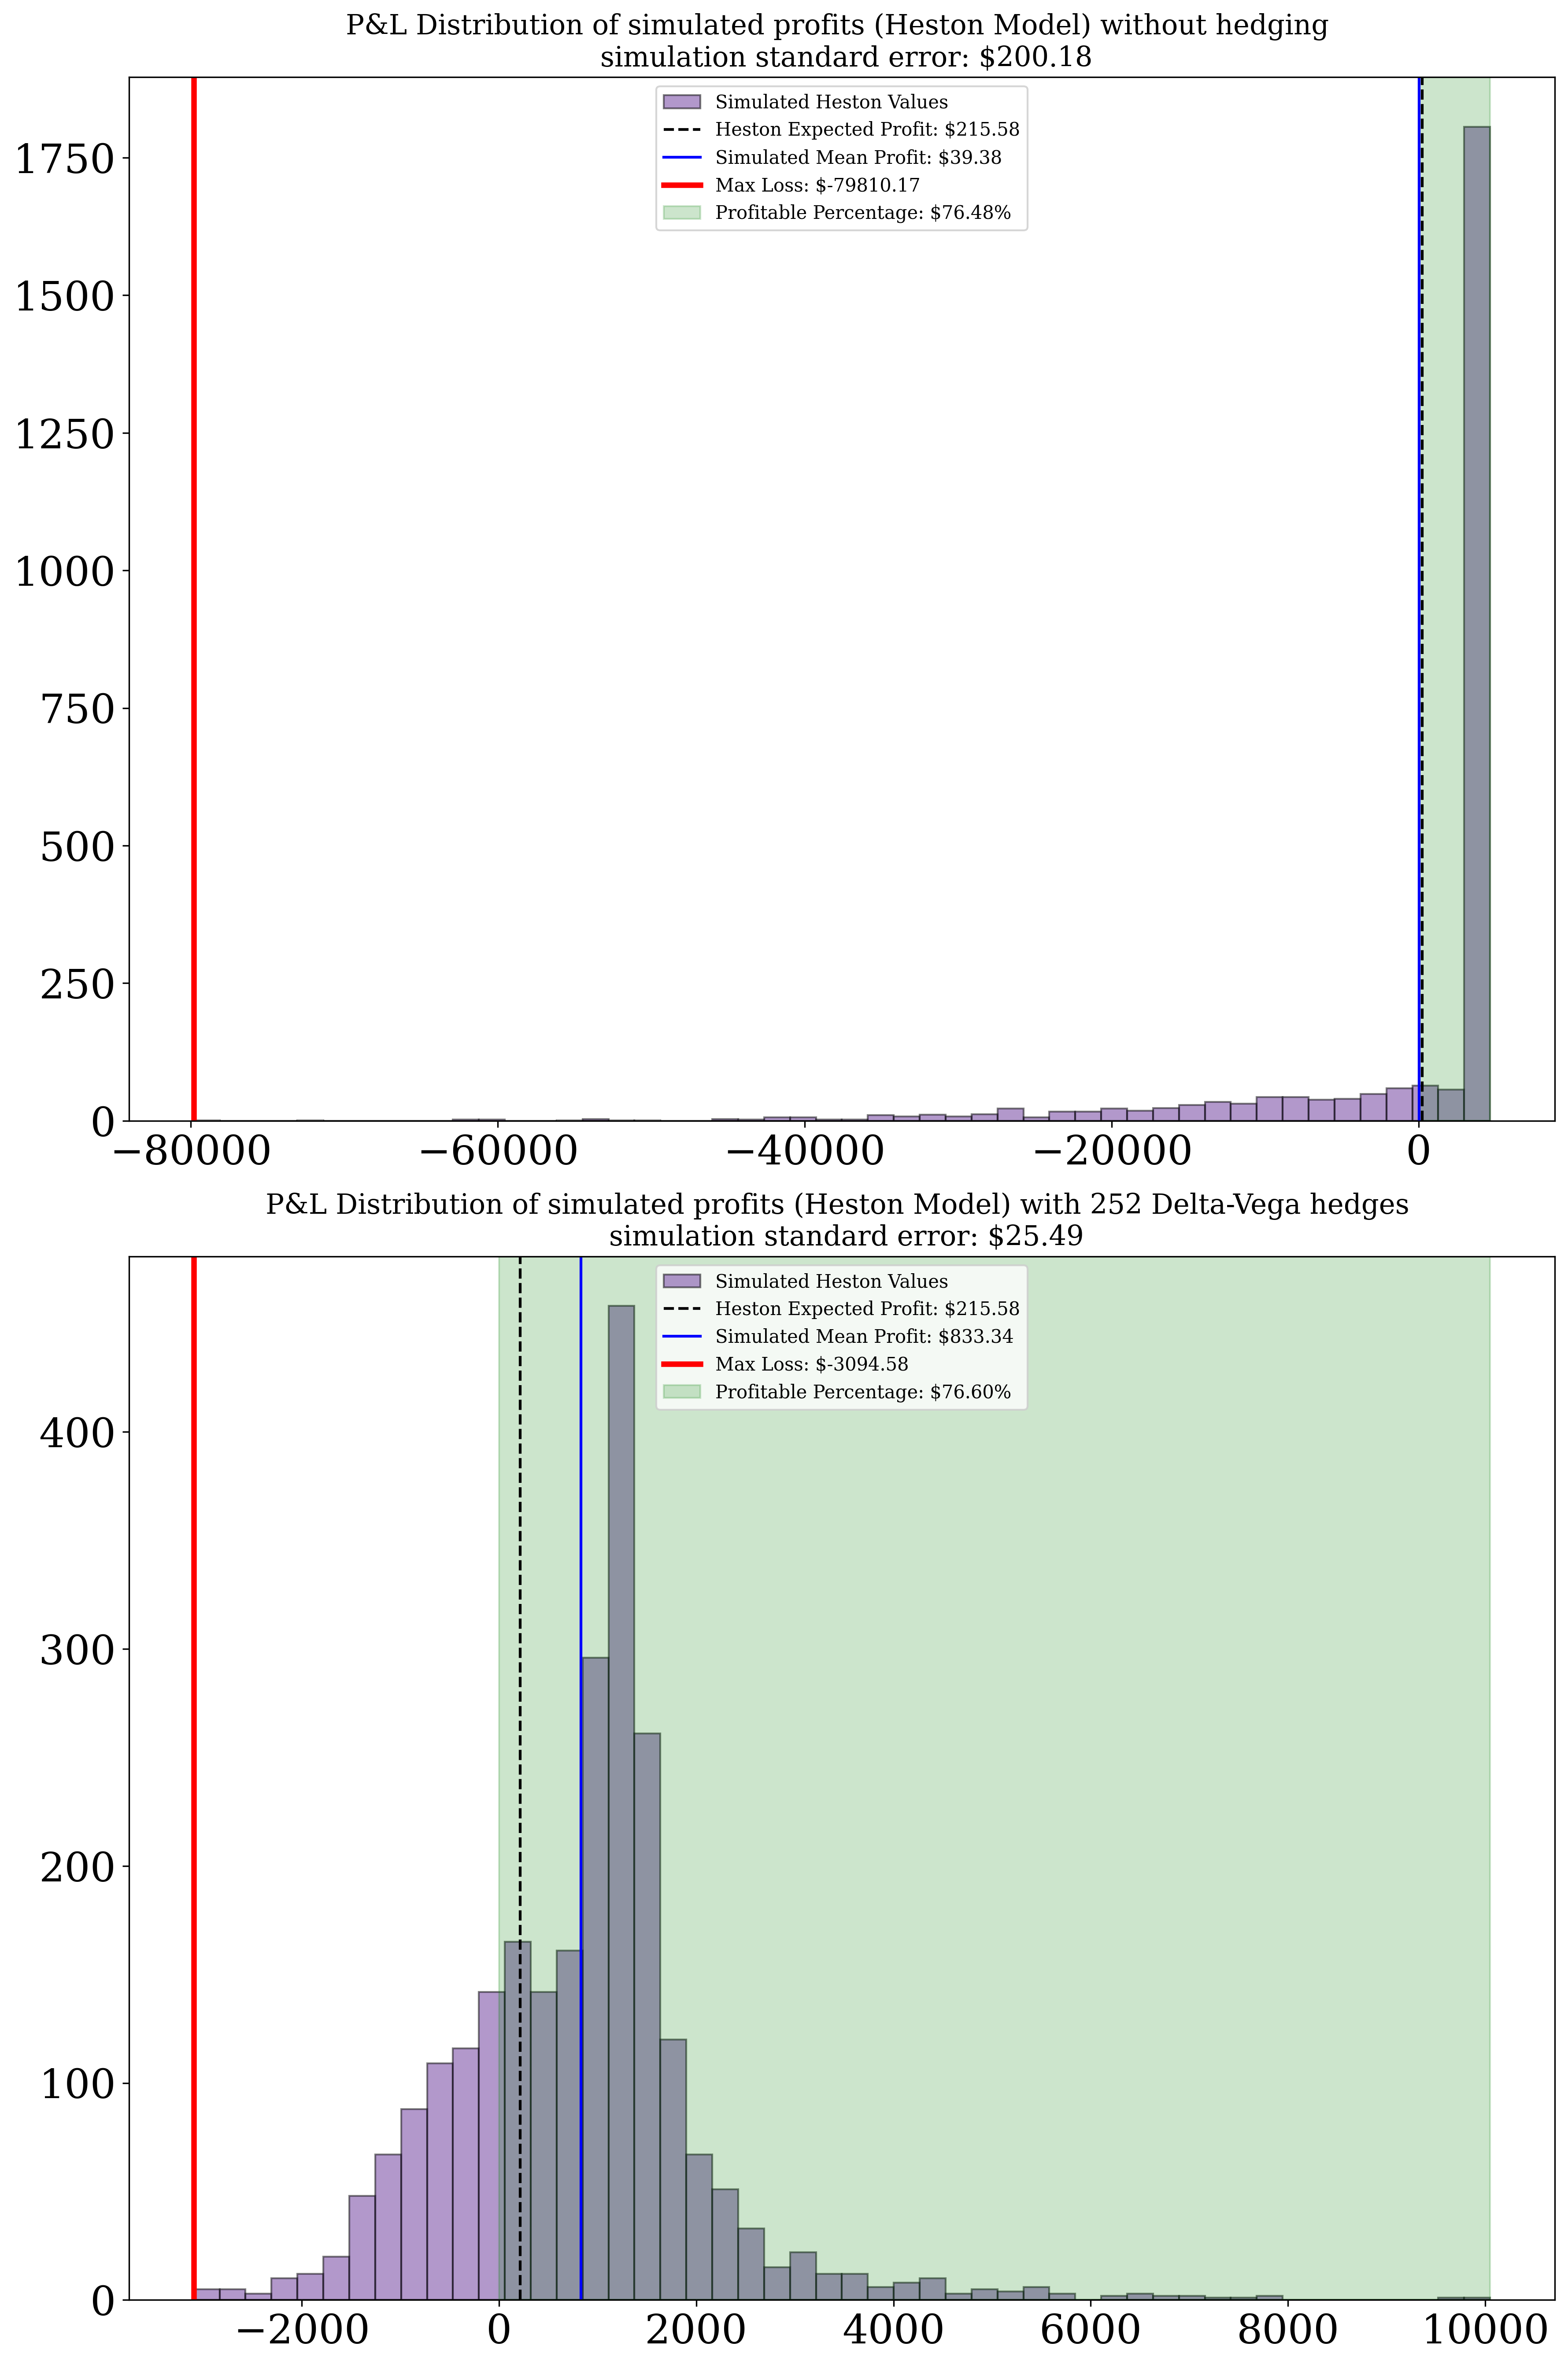

In [7]:
S0 = 85 #Initial Stock Value
K = 100
t = 1 #Time horizon
kappa = 2.4 #Mean reversion rate of variance of log-returns (Typical range 1 to 5)
theta = .3**2 #Long run variance of log-returns
xi = .43 # Volatility of Volatility (Typical range .2 to 1)
v0 = .22**2 #Initial variance of log-returns
rho = -.6 #Correlation of random noise of variance and log-returns (Typical range -.9 to -.4)
r = .039 #Risk-free interest rate
mu = r #Excess drift of log returns

n_sims = 2500  #Number of simulations
n_hedges = 252  # number of hedges
num_options = 1000

heston_premium= heston_call(S0, K, v0+0.01, r, t, kappa, theta, xi, rho)

heston_call_price = heston_call(S0, K, v0, r, t, kappa, theta, xi, rho)
sold_calls_hedged, sold_call_nohedge = heston_call_MC_delta_vega(S0, K, K+10, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims=2500, mu=0)
profits_hedged = num_options*(heston_premium - sold_calls_hedged)
profits_nohedge = num_options*(heston_premium - sold_call_nohedge)
profit_percent_hedged = np.mean(profits_hedged>=0)*100
profit_percent_nohedge = np.mean(profits_nohedge>=0)*100

fig,axes = plt.subplots(2,1, figsize = (12,18))

axes[0].hist(profits_nohedge, bins = 50, alpha = .5, color = 'rebeccapurple', edgecolor='black', label = 'Simulated Heston Values')
axes[1].hist(profits_hedged, bins = 50, alpha = .5, color = 'rebeccapurple', edgecolor='black', label = 'Simulated Heston Values')

axes[0].axvline(num_options*(heston_premium-heston_call_price), label = f'Heston Expected Profit: ${num_options*(heston_premium-heston_call_price):.2f}', color = 'black',linestyle="--")
axes[1].axvline(num_options*(heston_premium-heston_call_price), label = f'Heston Expected Profit: ${num_options*(heston_premium-heston_call_price):.2f}', color = 'black',linestyle="--")

axes[0].axvline(np.mean(profits_nohedge), label = f'Simulated Mean Profit: ${np.mean(profits_nohedge):.2f}', color = 'blue',linestyle="-")
axes[1].axvline(np.mean(profits_hedged), label = f'Simulated Mean Profit: ${np.mean(profits_hedged):.2f}', color = 'blue',linestyle="-")

axes[0].axvline(np.min(profits_nohedge), label = f'Max Loss: ${np.min(profits_nohedge):.2f}', color = 'red',linewidth=3)
axes[1].axvline(np.min(profits_hedged), label = f'Max Loss: ${np.min(profits_hedged):.2f}', color = 'red',linewidth=3)

axes[0].axvspan(0,np.max(profits_nohedge), color='green', alpha=0.2, label = f'Profitable Percentage: ${profit_percent_nohedge:.2f}%')
axes[1].axvspan(0,np.max(profits_hedged), color='green', alpha=0.2, label = f'Profitable Percentage: ${profit_percent_hedged:.2f}%')

axes[0].legend()
axes[1].legend()
axes[0].set_title(f'P&L Distribution of simulated profits (Heston Model) without hedging \n simulation standard error: ${np.std(profits_nohedge)/np.sqrt(n_sims):.2f}',size = 15)
axes[1].set_title(f'P&L Distribution of simulated profits (Heston Model) with {n_hedges} Delta-Vega hedges \n simulation standard error: ${np.std(profits_hedged)/np.sqrt(n_sims):.2f}',size = 15)
plt.tight_layout()
plt.savefig("Comparison.png")
plt.show()

## Observation 

When no hedge is applied, the simulated P&L distribution is highly left-skewed: most outcomes hover near breakeven, but a miniscule of paths experiences severe losses that stretch far into the negative tail. Introducing a daily delta hedge tightens the spread considerably. The left tail remains, yet it contracts to a fraction of its former width, and the distribution becomes more balanced around a mildly positive centre. Daily delta–vega hedging compresses the shape further still. The resulting histogram looks almost bell-shaped, with the extreme left tail largely clipped and a gentle right-hand skew arising from residual model mismatch.

In relative terms, each additional hedge layer removes a distinct risk. Delta hedging neutralises first-order price moves slashes path-to-path variance and catastrophic scenarios, but sizeable volatility shocks can still break through the hedge. The Delta–vega hedging further mutes those volatility shocks, flattening what remains of the loss tail and producing a noticeably calmer dispersion of outcomes.

Although the mean P&L drifts slightly rightward as more sensitivities are hedged—an artefact of using Black-Scholes Greeks in a stochastic-volatility world—the genuine payoff is the step-wise suppression of downside risk and variability. In short, delta–vega hedging preserves the core advantage of delta hedging while adding an extra shield against volatility risk, giving a substantially smoother and more symmetric P&L profile than either the unhedged or the delta-only strategy.